In [ ]:
%matplotlib inline
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import torch
import random
from python_speech_features import mfcc
import torch.nn as nn
from torch.autograd import Variable
from numpy import array
from matplotlib import pyplot as plt
import torch.nn.functional as F
from IPython.display import clear_output

In [117]:
class Config:
    def __init__(self, nfilt = 26, nfeat = 13, nfft = 2205, rate = 22050):
        self.nfeat = nfeat
        self.rate = rate
        self.nfilt = nfilt
        self.nfft = nfft
        self.classes = ['sathvik', 'merril', 'varun', 'kartik']
        self.val_files = ['kartik10.wav', 'kartik13.wav', 'merril10.wav', 'merril12.wav', 'sathvik20.wav', 
                          'sathvik22.wav', 'varun21.wav', 'varun22.wav']
        self.envelope_threshold = 0.04
        self.cuda = True
        self.no_cuda = False
        self.seed = 1
        self.epochs = 30
        self.lr = 0.0001
config = Config()

config.cuda = not config.no_cuda and torch.cuda.is_available()
torch.manual_seed(config.seed)
if config.cuda:
    torch.cuda.manual_seed(config.seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if config.cuda else {}

In [118]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center =True).mean()
    for mean in y_mean:
        if mean> threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [119]:
path = '../training_files_male/'

In [120]:
def label(file):
    for i, name in enumerate(config.classes):
        if file.startswith(name):
            return [i]

In [121]:
def chunks(file, signal, rate, window_size, sliding=False, slide_window_size=0):
    
    data = []
    label_ = []
    chunk_size = rate*window_size
    
    if sliding == False:
        
        n_chunks = int(len(signal)/(chunk_size)) + 1
        for i in range(n_chunks):
                chunk = signal[int(i*chunk_size):int((i+1)*chunk_size)]
                features = mfcc(chunk, rate, numcep = config.nfeat, nfilt = config.nfilt, nfft = config.nfft)
                data.append(features)
                label_.append(label(file))
        return data, label_
    
    elif sliding == True:
        
        slide_size = rate*slide_window_size
        n_chunks = int((len(signal)-chunk_size)/slide_size)
        for i in range(n_chunks):
            chunk = signal[int(i*slide_size) : int(chunk_size+(i*slide_size))]
            features = mfcc(chunk, rate, numcep = config.nfeat, nfilt = config.nfilt, nfft = config.nfft)
            data.append(features)
            label_.append(label(file))
        return data, label_

# Creating chunk files:
- Signal length corresponds to rate * no of seconds
- Initially make chunks before mfcc, 0.5, 0.8, 1, 1.5, 2 sec
- Chunk size = rate * window_length(in sec)
- then try chunks after mfcc

In [122]:
def load_data(window_size=0.5):
    
    data_test, data_train, target_test, target_train = [], [], [], []
    for file in tqdm(os.listdir(path)):

        signal, rate = librosa.load(os.path.join(path, file))
        mask = envelope(signal, rate, config.envelope_threshold)
        data, target = chunks(file, signal, rate, window_size, sliding=True, slide_window_size=0.1)

        if file in config.val_files:
            data_test.extend(data)
            target_test.extend(target)
        data_train.extend(data)
        target_train.extend(target)

    print(list(map(len, (data_train, target_train, data_test, target_test))))
    return data_train, target_train, data_test, target_test

In [123]:
data_train, target_train, data_test, target_test = load_data()


[6922, 6922, 798, 798]


In [124]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()      
        self.conv = nn.Conv1d(13, 30, kernel_size = 20,stride = 1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(10)
        self.fc = nn.Linear(300,30)
    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        out = out.view(-1, out.size(1)*out.size(2))
        out = self.fc(out)
        return out

In [125]:
class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = CNN()
        self.rnn = nn.LSTM(
            input_size = 30, 
            hidden_size = 64, 
            num_layers = 2,
            batch_first = True)
        self.linear = nn.Linear(64,4)
    def forward(self, x):
        C, H, W = x.size()
        c_in = x.view(1,W, C)  
        c_out = self.cnn(c_in)
        r_in = c_out.view(1, 1, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        a = F.log_softmax(r_out2, dim=1)
        return a

In [126]:
def get_data(data,target):

    data = torch.from_numpy(np.asarray(data));
    target = torch.from_numpy(array(target));
    
    return data,target

In [127]:
def train(epoch):
    
    training_loss, correct, m = 0, 0, 0
    model.train()
    c = []
    for i in range(1,len(data_train)+1):
        c.append(i)
    random.shuffle(c)
    plt.show()

    for i in tqdm(range(1,len(data_train)-1)): 
        data,target = get_data(data_train[c[i]-1],target_train[c[i]-1])

        data = np.expand_dims(data, axis=1)
        data = torch.FloatTensor(data)
        
        if config.cuda:
            data, target = data.cuda(), target.cuda()
         
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = F.nll_loss(output, target)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()        
        
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        m = m+1
        
    return training_loss/len(data_train), (correct*100/m)

In [128]:
with torch.no_grad():
    def test(epoch):
        
        model.eval()
        test_loss = 0
        correct = 0
        m = 0
        c = []
        
        for i in range(1,len(data_test)+1):
            c.append(i)
        random.shuffle(c)
        
        for i in range(1,len(data_test)-1):
            data,target = get_data(data_test[c[i]-1],target_test[c[i]-1])
            data = np.expand_dims(data, axis=1)
            data = torch.FloatTensor(data)
            if config.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            target = target.long()
            test_loss += F.nll_loss(output, target).sum().item()  
            pred = output.data.max(1, keepdim=True)[1] 
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
            m = m+1
        
        correct = correct.numpy()
        return test_loss/len(data_test), (correct*100/m)

In [129]:
def save_checkpoint(teacc, epoch, max_acc, ep_count):
    if teacc>max_acc: 
        max_acc = teacc
        ep_count = epoch
        torch.save(model.state_dict(), '../models/checkpoint.pth' )
    if epoch == config.epochs-1:
        print('Max test accuracy {0:.{1}f}% obtained at epoch {2}'.format(max_acc, 2, ep_count))

In [130]:
def plot_graphs(x, y, title):
    plt.plot(x, label = 'train')
    plt.legend()
    plt.plot(y, label = 'test')
    plt.legend()
    plt.title(title)
    plt.show()

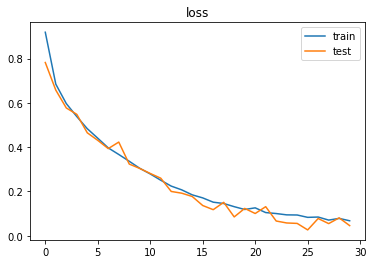

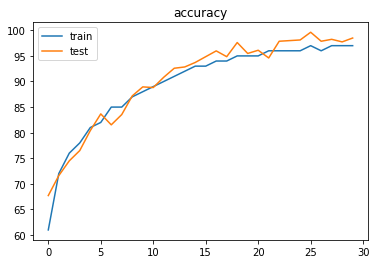

Max test accuracy 98.49% obtained at epoch 29


In [131]:
max_acc = 0
ep_count = 0

def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_normal_(m.weight.data)
        
model = Combine()
model.apply(weights_init)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=(0.95,0.999))
tr_loss, te_loss, tr_acc, te_acc = [], [], [], []

for epoch in range(config.epochs):
    trloss, tracc = train(epoch)
    teloss, teacc = test(epoch)
    tr_loss.append(trloss)
    te_loss.append(teloss)
    tr_acc.append(tracc)
    te_acc.append(teacc)
    clear_output()
    plot_graphs(tr_loss, te_loss, 'loss')
    plot_graphs(tr_acc, te_acc, 'accuracy')   
    save_checkpoint(teacc, epoch, max_acc, ep_count)

In [40]:
# torch.save(model.state_dict(), '../models/4class_chunks_1.5s.pth' )

In [132]:
# model = Combine()
# model.load_state_dict(torch.load('../models/checkpoint.pth'))
# torch.save(model.state_dict(), '../models/4class_chunks_0.5s_0.1soverlap.pth' )